# **Interest Rates Modeling**

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Load data

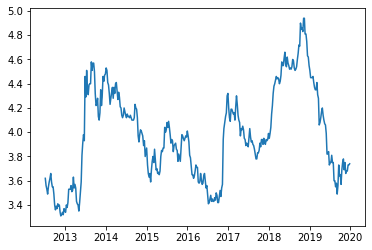

In [22]:
# Get path
root_folder = os.getcwd()
data_folder = "data"
data_path = os.path.join(root_folder, data_folder)

# load LIBOR data
data = pd.read_excel(os.path.join(root_folder, data_folder, 'MORTGAGE30US.xlsx'), index_col='Dates')

# Drop any nan value
data = data.dropna()
plt.plot(data)
plt.show()

In [23]:
# We'll use R libraries to perform change-point analysis
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

sde = importr('sde')
stats = importr('stats')

## Change-point analysis

In [24]:
# Convert data from Pandas.DataFrame to R-format
with localconverter(ro.default_converter + pandas2ri.converter):
  r_data = ro.conversion.py2rpy(data)

# Convert vector to time series
rts_data = stats.ts(r_data)

# Change-ponint analysis
out_cpoint = sde.cpoint(rts_data)

# Extract $tau1 (index of change-point)
cpoint = int(np.array(out_cpoint[1]))

In [25]:
# Limit data
data = data[cpoint:]

data.iloc[0]

PX_LAST    4.42
Name: 2013-12-12 00:00:00, dtype: float64

## Calibration via OLS

#### Ho-Lee model

In [27]:
HL_theta1 = float(data.diff().mean())
HL_theta2 = float(data.diff().std())

In [28]:
HL_theta1, HL_theta2

(-0.0021587301587301577, 0.06308249738310445)

#### Ornstein–Uhlenbeck model | diff(r) = \theta_1 - \theta_2 * r + \theta_3 * \epsilon

In [29]:
y = data.diff().dropna()
x = data[1:]

reg = LinearRegression().fit(x, y)

OU_theta1 = - float(reg.intercept_)
OU_theta2 = float(reg.coef_)
OU_theta3 = float(np.std(y - reg.predict(x)))

In [30]:
OU_theta1, OU_theta2, OU_theta3

(0.06455724088770388, 0.015493997965951743, 0.06275161740596615)

#### Cox-Ingersoll-Ross model | diff(r) / sqrt(r) = (\theta_1) / sqrt(r) - \theta_2 * r + \theta_3 * \epsilon

In [31]:
y = (data.diff()[1:] / np.sqrt(data.shift())).dropna()
x_1 = 1 / np.sqrt(data.shift())
x_2 = np.sqrt(data.shift())
x = pd.concat([x_1, x_2], axis=1).dropna()

reg = LinearRegression(fit_intercept=False).fit(x, y)

CIR_theta1 = reg.coef_[0, 0]
CIR_theta2 = - reg.coef_[0, 1]
CIR_theta3 = float(np.std(y - reg.predict(x)))

In [32]:
CIR_theta1, CIR_theta2, CIR_theta3

(0.07203688277584017, 0.018413432976742285, 0.03144910338423493)

## Simulation

In [33]:
paths = 1000
grid_points = len(data)
dt = 1/252

# Random Generator instance
rng = np.random.default_rng()

#### Ho-Lee model

In [34]:
HL_rates = np.empty([paths, grid_points])
HL_rates.T[0] = data.iloc[0].PX_LAST

for path_idx in range(paths):
    for idx in range(grid_points - 1):
        HL_rates[path_idx, idx + 1] = (
            HL_rates[path_idx, idx] + HL_theta1 + HL_theta2 * rng.standard_normal()
        )

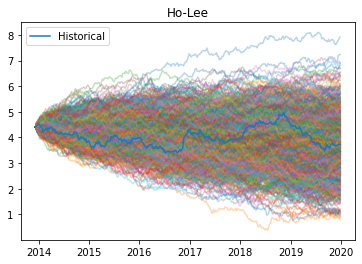

In [35]:
fig, ax1 = plt.subplots(1, 1)
fig.patch.set_facecolor('white')
ax1.plot(np.array([data.index] * 1000).T, HL_rates.T, alpha=0.3)
ax1.plot(data, alpha=1, label='Historical')
ax1.set_title("Ho-Lee")
ax1.legend()
plt.show()

#### Ornstein–Uhlenbeck model

In [36]:
OU_rates = np.empty([paths, grid_points])
OU_rates.T[0] = data.iloc[0].PX_LAST

for path_idx in range(paths):
    for idx in range(grid_points - 1):
        OU_rates[path_idx, idx + 1] = (
            OU_rates[path_idx, idx] + (OU_theta1 - OU_theta2 * OU_rates[path_idx, idx])
            + OU_theta3 * rng.standard_normal()
        )

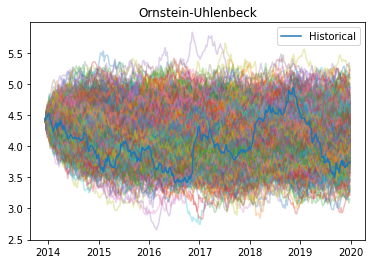

In [37]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(np.array([data.index] * 1000).T, OU_rates.T, alpha=0.3)
ax1.plot(data, alpha=1, label='Historical')
ax1.set_title("Ornstein-Uhlenbeck")
ax1.legend()
plt.show()

#### Cox-Ingersoll-Ross model

In [38]:
CIR_rates = np.empty([paths, grid_points])
CIR_rates.T[0] = data.iloc[0].PX_LAST
for path_idx in range(paths):
    for idx in range(grid_points - 1):
        CIR_rates[path_idx, idx + 1] = (
            CIR_rates[path_idx, idx] + (CIR_theta1 - CIR_theta2 * CIR_rates[path_idx, idx])
            + CIR_theta3 * rng.standard_normal() * np.sqrt(CIR_rates[path_idx, idx]))

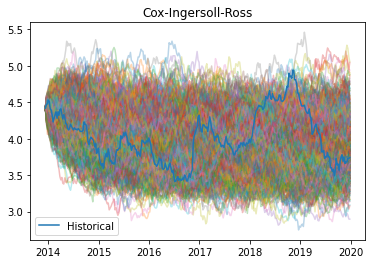

In [39]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(np.array([data.index] * 1000).T, CIR_rates.T, alpha=0.3)
ax1.plot(data, alpha=1, label='Historical')
ax1.set_title("Cox-Ingersoll-Ross")
ax1.legend()
plt.show()

## Goodness of fit (density functions)

#### Ho-Lee model

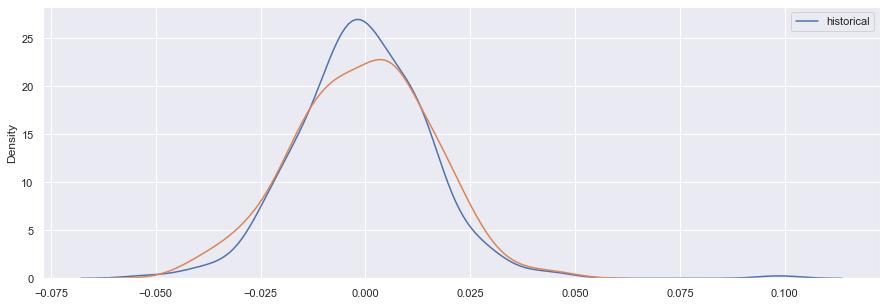

In [40]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(np.diff(np.log(data.PX_LAST)), label='historical')
sns.kdeplot(np.diff(np.log(HL_rates[0])))
plt.legend()
plt.show()

#### Ornstein–Uhlenbeck model

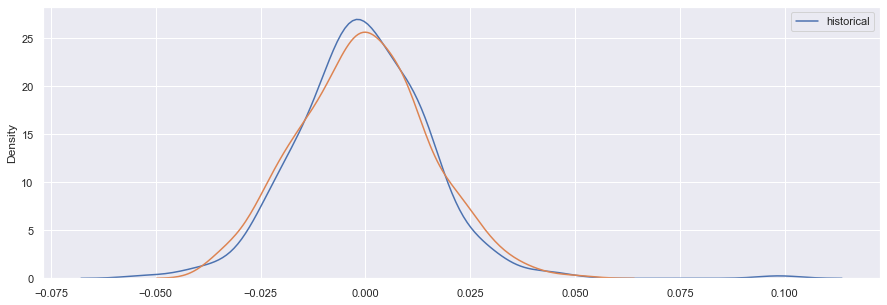

In [41]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(np.diff(np.log(data.PX_LAST)), label='historical')
sns.kdeplot(np.diff(np.log(OU_rates[0])))
plt.legend()
plt.show()

#### Cox-Ingersoll-Ross model

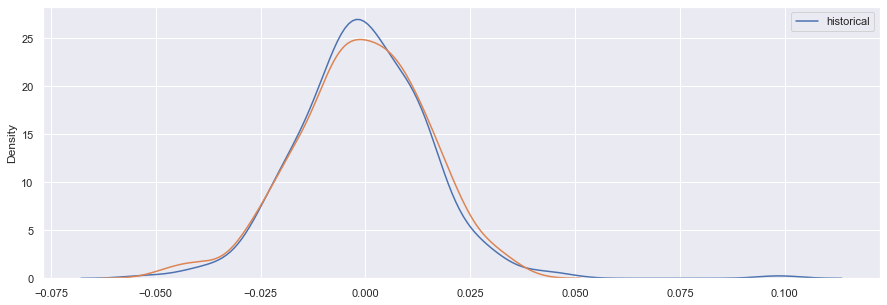

In [42]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(np.diff(np.log(data.PX_LAST)), label='historical')
sns.kdeplot(np.diff(np.log(CIR_rates[0])))
plt.legend()
plt.show()

## Goodness of fit (Kolmogorov-Smirnov test)

### Ho-Lee model

In [43]:
stats.ks_2samp(np.diff(np.log(data.PX_LAST)), np.diff(np.log(HL_rates[2])))

KstestResult(statistic=0.1492063492063492, pvalue=0.0017739247357800793)

#### Ornstein–Uhlenbeck process

In [44]:
stats.ks_2samp(np.diff(np.log(data.PX_LAST)), np.diff(np.log(OU_rates[0])))

KstestResult(statistic=0.047619047619047616, pvalue=0.8682103977154014)

#### Cox-Ingersoll-Ross process

In [45]:
stats.ks_2samp(np.diff(np.log(data.PX_LAST)), np.diff(np.log(CIR_rates[0])))


KstestResult(statistic=0.047619047619047616, pvalue=0.8682103977154014)